### Imports

In [10]:
# Get report data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import environment, path_planner, visualizer, acrobot, trajectory_optimization, analysis
import importlib
from collections import namedtuple 
from pydrake.all import (MultibodyPlant, Parser, RigidTransform, PiecewisePolynomial)
importlib.reload(environment)
importlib.reload(path_planner)
importlib.reload(visualizer)
importlib.reload(acrobot)
importlib.reload(trajectory_optimization)
importlib.reload(analysis)
from acrobot import Acrobot
from visualizer import AcrobotVisualizer
from environment import Environment
from path_planner import AStarPathPlanner, EnergyPathPlanner, TrajectoryMatchPathPlanner
from trajectory_optimization import DirectCollocationParameters, DirectCollocationTrajectoryGenerator
from analysis import get_total_effort

### Path Generation

Distance-based:
Energy-based:
Trajectory cost-based:


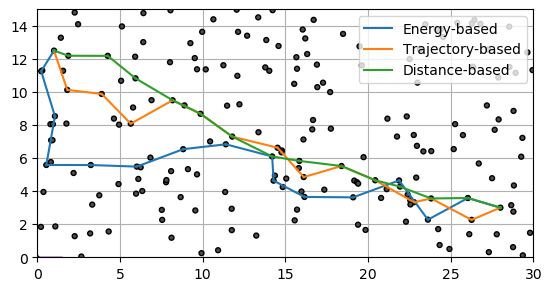

In [ ]:
plant = MultibodyPlant(time_step=0)
parser = Parser(plant)
parser.AddModels("acrobot.urdf")
plant.WeldFrames(
    plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity()
)
plant.Finalize()

env = Environment()
env.generate_random_uniform((0, 30, 0, 15), (1, 12.5), (28, 3),200)
bot = Acrobot(plant)
vis = AcrobotVisualizer(bot,env)
trajectory_inputs = np.genfromtxt("collocation_sim_results.csv", delimiter=',', skip_header=1)
print("Distance-based:")
dist_planner = AStarPathPlanner(env)
dist_path = dist_planner.calculate_path()
print("Energy-based:")
energy_planner = EnergyPathPlanner(env)
energy_path = energy_planner.calculate_path()
print("Trajectory cost-based:")
traj_match_planner = TrajectoryMatchPathPlanner(env, trajectory_inputs)
traj_path = traj_match_planner.calculate_path()
paths = {
    "Energy-based": energy_planner.calculate_path(),
    "Trajectory-based": traj_match_planner.calculate_path(),
    "Distance-based": dist_planner.calculate_path()
}
file_path = "./env_plot/A_star_test.png"
# planner.plot(env, paths, file_path)


vis.draw_path(paths)
vis.ax.legend(loc="upper right")



## Analysis

### Trajectory-Based

In [ ]:
# Run trajectory optimization on the Trajectory-based plan
SimulationResult = namedtuple('SimulationResult',['current_hold', 'total_segment_input', 'path_info', 'start_hold_error', 'goal_hold_error'])

simulation = SimulationResult(current_hold=np.zeros(len(paths["Trajectory-based"])), 
                              total_segment_input=np.zeros(len(paths["Trajectory-based"])), 
                              path_info=np.zeros((len(paths["Trajectory-based"]),
                                                 np.size(traj_match_planner.trajectory_inputs,1))),
                              start_hold_error=np.zeros(len(paths["Trajectory-based"])), 
                              goal_hold_error=np.zeros(len(paths["Trajectory-based"]))
                              )

for i, hold_index in enumerate(paths["Trajectory-based"]):
    simulation.current_hold[i] = hold_index
    
    #find path info
    prev_hold = None
    next_hold = None
    if i != 0:
        prev_hold = paths["Trajectory-based"][i-1]
    if i != len(paths["Trajectory-based"])-1:
        next_hold = paths["Trajectory-based"][i+1]
        simulation.path_info[i] = traj_match_planner.chosen_trajectories[(prev_hold, hold_index, next_hold)]
        
        if i != 0:
            diff = env.get_relative_position(hold_index,prev_hold) - simulation.path_info[i,0:2]
        else:
            diff = np.array([0,-traj_match_planner.range]) - simulation.path_info[i,0:2]
        goal_diff = env.get_relative_position(hold_index,next_hold) - simulation.path_info[i,2:4]
        simulation.start_hold_error[i] = np.sqrt(np.dot(diff,diff))
        simulation.goal_hold_error[i] = np.sqrt(np.dot(goal_diff,goal_diff))
    

effort = 0
results = []
i = 0
start_state = np.zeros(4)

for i, curr_hold in enumerate(simulation.current_hold[0:-1]):
    print("Evaluating step {}/{}...".format(i, len(simulation.current_hold[0:-2])))
    # Set up DirectCollocation
    opts = DirectCollocationParameters()
    traj_opt = DirectCollocationTrajectoryGenerator(bot, opts)
    traj_opt.params.time_cost = simulation.path_info[i,4]
    traj_opt.params.R = simulation.path_info[i,5]

    sol = traj_opt.generate_trajectory(start_state, env.holds[int(simulation.current_hold[i+1])].position)
    if sol.is_success():
        # x_traj = traj_opt.collocation_prog.ReconstructStateTrajectory(sol)
        u_traj = traj_opt.collocation_prog.ReconstructInputTrajectory(sol)

        # trajectories = {1:x_traj, 2:u_traj}
        effort = get_total_effort(u_traj, 1)
    else:
        effort = -1        
    # results.append(np.array([time_cost, input_cost, effort]))
    simulation.total_segment_input[i] = effort
    
    # Set the start state of the bot for the next iteration 
    start_pos = env.get_relative_position(simulation.current_hold[i+1], curr_hold)
    start_state = np.hstack((bot.get_joint_angles(start_pos,start_pos[0] > 0), np.zeros(2)))

print("Trajectory-based path planning:")
print("Total planned effort: {}".format(np.sum(simulation.path_info[:,7])))
print("Total calculated effort: {}".format(np.sum(simulation.total_segment_input)))

Evaluating step 0/13...
Evaluating step 1/13...
Evaluating step 2/13...
Evaluating step 3/13...
Evaluating step 4/13...
Evaluating step 5/13...
Evaluating step 6/13...
Evaluating step 7/13...
Evaluating step 8/13...
Evaluating step 9/13...
Evaluating step 10/13...
Evaluating step 11/13...
Evaluating step 12/13...
Evaluating step 13/13...
Trajectory-based path planning:
Total planned effort: 1.668045561327636
Total calculated effort: 11.567775331072365


In [7]:
# Collect the stats for each step of the trajectory-based plan, after simulation
traj_stats = []
for i, curr_hold in enumerate(simulation.current_hold):
    row = {
        "Step": i,
        "Hold": curr_hold,
        "Plan": simulation.path_info[i, 7],
        "Calc": simulation.total_segment_input[i],
        "Diff": simulation.total_segment_input[i] - simulation.path_info[i, 7],
        "Start Error": simulation.start_hold_error[i],
        "Goal Error": simulation.goal_hold_error[i]
    }
    traj_stats.append(row)
traj_stats = pd.DataFrame(traj_stats)
print(traj_stats)

    Step   Hold      Plan      Calc      Diff  Start Error  Goal Error
0      0    0.0  0.358997  2.876794  2.517797     0.000000    0.492603
1      1  140.0  1.031912  1.788171  0.756259     0.492603    0.224485
2      2   31.0  0.038235  0.612135  0.573900     0.224485    0.515427
3      3   91.0  0.006554  1.538196  1.531642     0.515427    0.363053
4      4   37.0  0.098235  0.021199 -0.077036     0.363053    0.484711
5      5   66.0  0.010726  4.523445  4.512719     0.484711    0.303348
6      6   58.0  0.010218  0.058837  0.048620     0.303348    0.278473
7      7  151.0  0.006393  0.015585  0.009193     0.278473    0.478707
8      8  194.0  0.007484  0.024827  0.017344     0.478707    0.325834
9      9   68.0  0.007070  0.042287  0.035217     0.325834    0.398043
10    10  103.0  0.014004  0.008469 -0.005535     0.398043    0.443099
11    11   87.0  0.007371  0.005271 -0.002100     0.443099    0.263537
12    12  133.0  0.015486  0.045213  0.029727     0.263537    0.470689
13    

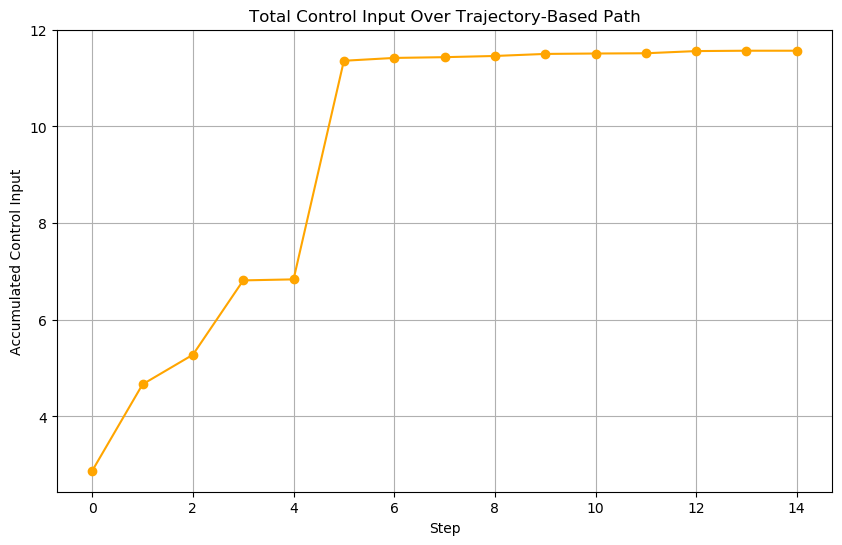

In [17]:
# Plot accumulated control over trajectory-based path
plt.figure(figsize=(10, 6))
plt.plot(np.array(traj_stats["Step"]),np.array( traj_stats["Calc"]).cumsum(), marker='o', color='orange')
plt.xlabel("Step")
plt.ylabel("Accumulated Control Input")
plt.title("Total Control Input Over Trajectory-Based Path")
plt.grid(True)
plt.show()

### Energy-Based

In [30]:
# Run trajectory optimization on the Energy-based plan
SimulationResult = namedtuple('SimulationResult',['current_hold', 'total_segment_input'])

simulation = SimulationResult(current_hold=np.zeros(len(paths["Energy-based"])), 
                              total_segment_input=np.zeros(len(paths["Energy-based"]))
                              )

for i, hold_index in enumerate(paths["Energy-based"]):
    simulation.current_hold[i] = hold_index
    
    #find path info
    prev_hold = None
    next_hold = None
    if i != 0:
        prev_hold = paths["Energy-based"][i-1]
    if i != len(paths["Energy-based"])-1:
        next_hold = paths["Energy-based"][i+1]        
        # if i != 0:
        #     diff = env.get_relative_position(hold_index,prev_hold) - simulation.path_info[i,0:2]
        # else:
        #     diff = np.array([0,-energy_planner.range]) - simulation.path_info[i,0:2]
        # goal_diff = env.get_relative_position(hold_index,next_hold) - simulation.path_info[i,2:4]
        # simulation.start_hold_error[i] = np.sqrt(np.dot(diff,diff))
        # simulation.goal_hold_error[i] = np.sqrt(np.dot(goal_diff,goal_diff))
    

effort = 0
results = []
i = 0
start_state = np.zeros(4)

for i, curr_hold in enumerate(simulation.current_hold[0:-1]):
    print("Evaluating step {}/{}...".format(i, len(simulation.current_hold[0:-2])))
    # Set up DirectCollocation
    opts = DirectCollocationParameters()
    traj_opt = DirectCollocationTrajectoryGenerator(bot, opts)
    # traj_opt.params.time_cost = simulation.path_info[i,4]
    # traj_opt.params.R = simulation.path_info[i,5]

    sol = traj_opt.generate_trajectory(start_state, env.holds[int(simulation.current_hold[i+1])].position)
    if sol.is_success():
        # x_traj = traj_opt.collocation_prog.ReconstructStateTrajectory(sol)
        u_traj = traj_opt.collocation_prog.ReconstructInputTrajectory(sol)

        # trajectories = {1:x_traj, 2:u_traj}
        effort = get_total_effort(u_traj, 1)
    else:
        effort = -1        
    # results.append(np.array([time_cost, input_cost, effort]))
    simulation.total_segment_input[i] = effort
    
    # Set the start state of the bot for the next iteration 
    start_pos = env.get_relative_position(simulation.current_hold[i+1], curr_hold)
    start_state = np.hstack((bot.get_joint_angles(start_pos,start_pos[0] > 0), np.zeros(2)))

print("Energy-based path planning:")
print("Total calculated effort: {}".format(np.sum(simulation.total_segment_input)))

Evaluating step 0/14...
Evaluating step 1/14...
Evaluating step 2/14...
Evaluating step 3/14...
Evaluating step 4/14...
Evaluating step 5/14...
Evaluating step 6/14...
Evaluating step 7/14...
Evaluating step 8/14...
Evaluating step 9/14...
Evaluating step 10/14...
Evaluating step 11/14...
Evaluating step 12/14...
Evaluating step 13/14...
Evaluating step 14/14...
Energy-based path planning:
Total calculated effort: 7.639796836551558


In [31]:
# Collect the stats for each step of the energy-based plan, after simulation
energy_stats = []
for i, curr_hold in enumerate(simulation.current_hold):
    row = {
        "Step": i,
        "Hold": curr_hold,
        "Calc": simulation.total_segment_input[i]
    }
    energy_stats.append(row)
energy_stats = pd.DataFrame(energy_stats)
print(energy_stats)

    Step   Hold      Calc
0      0    0.0 -1.000000
1      1   95.0 -1.000000
2      2  139.0  2.474116
3      3   21.0  1.089157
4      4  175.0  0.401272
5      5  104.0  0.162332
6      6  107.0  0.153518
7      7  148.0  0.559770
8      8  159.0  0.162487
9      9  189.0  0.378932
10    10  100.0  0.525036
11    11   54.0  0.153756
12    12   38.0  1.403267
13    13  106.0  1.764322
14    14   25.0  0.411832
15    15    1.0  0.000000


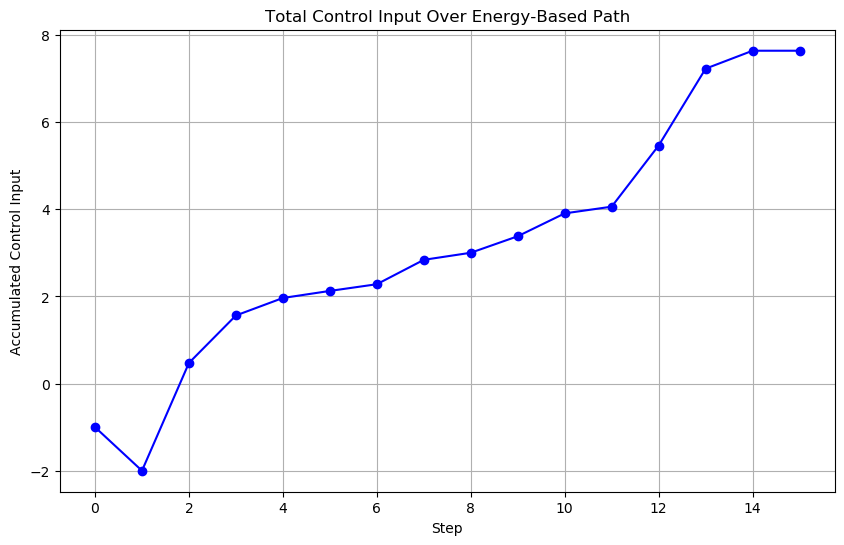

In [32]:
# Plot accumulated control over energy-based path
plt.figure(figsize=(10, 6))
plt.plot(np.array(energy_stats["Step"]),np.array( energy_stats["Calc"]).cumsum(), marker='o', color='blue')
plt.xlabel("Step")
plt.ylabel("Accumulated Control Input")
plt.title("Total Control Input Over Energy-Based Path")
plt.grid(True)
plt.show()

### Distance-Based

In [33]:
# Run trajectory optimization on the Distance-based plan
SimulationResult = namedtuple('SimulationResult',['current_hold', 'total_segment_input'])

simulation = SimulationResult(current_hold=np.zeros(len(paths["Distance-based"])), 
                              total_segment_input=np.zeros(len(paths["Distance-based"]))
                              )

for i, hold_index in enumerate(paths["Distance-based"]):
    simulation.current_hold[i] = hold_index
    
    #find path info
    prev_hold = None
    next_hold = None
    if i != 0:
        prev_hold = paths["Distance-based"][i-1]
    if i != len(paths["Distance-based"])-1:
        next_hold = paths["Distance-based"][i+1]        
        # if i != 0:
        #     diff = env.get_relative_position(hold_index,prev_hold) - simulation.path_info[i,0:2]
        # else:
        #     diff = np.array([0,-energy_planner.range]) - simulation.path_info[i,0:2]
        # goal_diff = env.get_relative_position(hold_index,next_hold) - simulation.path_info[i,2:4]
        # simulation.start_hold_error[i] = np.sqrt(np.dot(diff,diff))
        # simulation.goal_hold_error[i] = np.sqrt(np.dot(goal_diff,goal_diff))
    

effort = 0
results = []
i = 0
start_state = np.zeros(4)

for i, curr_hold in enumerate(simulation.current_hold[0:-1]):
    print("Evaluating step {}/{}...".format(i, len(simulation.current_hold[0:-2])))
    # Set up DirectCollocation
    opts = DirectCollocationParameters()
    traj_opt = DirectCollocationTrajectoryGenerator(bot, opts)
    # traj_opt.params.time_cost = simulation.path_info[i,4]
    # traj_opt.params.R = simulation.path_info[i,5]

    sol = traj_opt.generate_trajectory(start_state, env.holds[int(simulation.current_hold[i+1])].position)
    if sol.is_success():
        # x_traj = traj_opt.collocation_prog.ReconstructStateTrajectory(sol)
        u_traj = traj_opt.collocation_prog.ReconstructInputTrajectory(sol)

        # trajectories = {1:x_traj, 2:u_traj}
        effort = get_total_effort(u_traj, 1)
    else:
        effort = -1        
    # results.append(np.array([time_cost, input_cost, effort]))
    simulation.total_segment_input[i] = effort
    
    # Set the start state of the bot for the next iteration 
    start_pos = env.get_relative_position(simulation.current_hold[i+1], curr_hold)
    start_state = np.hstack((bot.get_joint_angles(start_pos,start_pos[0] > 0), np.zeros(2)))

print("Distance-based path planning:")
print("Total calculated effort: {}".format(np.sum(simulation.total_segment_input)))

Evaluating step 0/13...
Evaluating step 1/13...
Evaluating step 2/13...
Evaluating step 3/13...
Evaluating step 4/13...
Evaluating step 5/13...
Evaluating step 6/13...
Evaluating step 7/13...
Evaluating step 8/13...
Evaluating step 9/13...
Evaluating step 10/13...
Evaluating step 11/13...
Evaluating step 12/13...
Evaluating step 13/13...
Distance-based path planning:
Total calculated effort: 17.77698769501919


In [34]:
# Collect the stats for each step of the dist-based plan, after simulation
dist_stats = []
for i, curr_hold in enumerate(simulation.current_hold):
    row = {
        "Step": i,
        "Hold": curr_hold,
        "Calc": simulation.total_segment_input[i]
    }
    dist_stats.append(row)
dist_stats = pd.DataFrame(dist_stats)
print(dist_stats)

    Step   Hold      Calc
0      0    0.0  2.546497
1      1   11.0  2.855262
2      2   19.0  1.776142
3      3  149.0  1.484741
4      4   37.0  2.295597
5      5   66.0  0.919191
6      6   58.0  0.091700
7      7  159.0  0.373419
8      8  108.0  0.748936
9      9   68.0  1.216080
10    10  103.0  0.126507
11    11   98.0  1.189765
12    12  133.0  0.509530
13    13   25.0  1.643620
14    14    1.0  0.000000


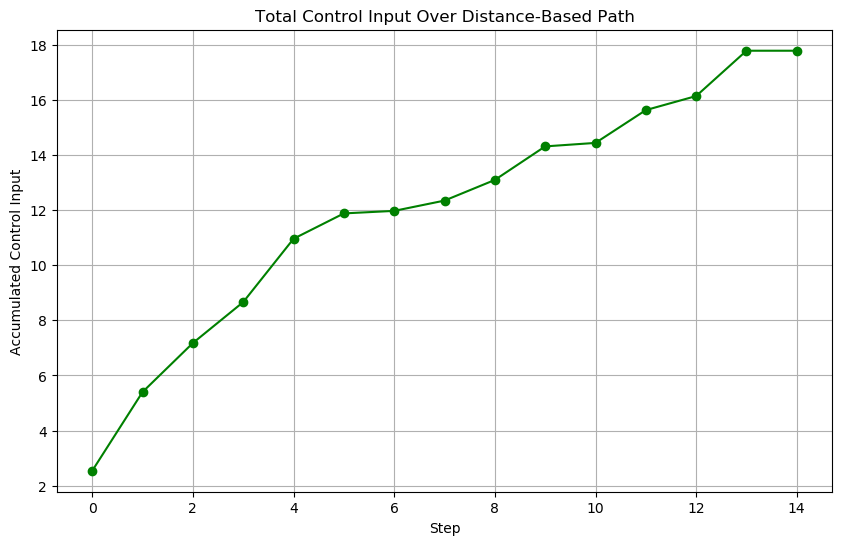

In [37]:
# Plot accumulated control over dist-based path
plt.figure(figsize=(10, 6))
plt.plot(np.array(dist_stats["Step"]),np.array(dist_stats["Calc"]).cumsum(), marker='o', color='green')
plt.xlabel("Step")
plt.ylabel("Accumulated Control Input")
plt.title("Total Control Input Over Distance-Based Path")
plt.grid(True)
plt.show()

### Comparison

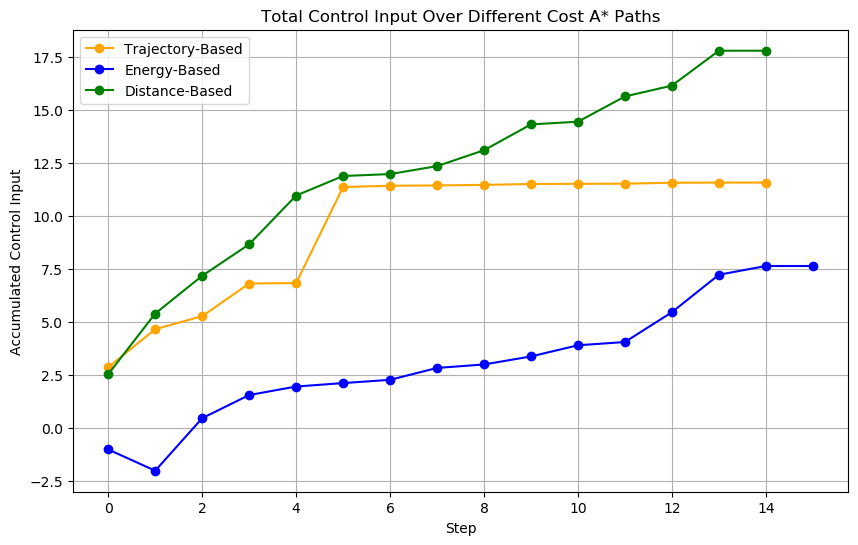

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(traj_stats["Step"]), np.array(traj_stats["Calc"]).cumsum(), marker='o', label="Trajectory-Based", color='orange')
plt.plot(np.array(energy_stats["Step"]), np.array(energy_stats["Calc"]).cumsum(), marker='o', label="Energy-Based", color='blue')
plt.plot(np.array(dist_stats["Step"]), np.array(dist_stats["Calc"]).cumsum(), marker='o', label="Distance-Based", color='green')

plt.xlabel("Step")
plt.ylabel("Accumulated Control Input")
plt.title("Total Control Input Over Different Cost A* Paths")
plt.legend()
plt.grid(True)
plt.show()